In [1]:
import os
os.path

from datetime import datetime, timedelta
import cmocean

import pyproj
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import trajan as ta
import pandas as pd

import opendrift
from opendrift.models.leeway import Leeway
from opendrift.readers import reader_netCDF_CF_generic
from opendrift.models.physics_methods import wind_drift_factor_from_trajectory, distance_between_trajectories, skillscore_liu_weissberg

import cartopy.crs as ccrs
from matplotlib.lines import Line2D

from scipy.spatial import ConvexHull, convex_hull_plot_2d

import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature
from matplotlib.lines import Line2D

In [2]:
reader_globcur = reader_netCDF_CF_generic.Reader("C:/Users/bente/Documents/THESIS/Globcurrent/*.nc")
reader_wind = reader_netCDF_CF_generic.Reader('C:/Users/bente/Documents/THESIS/Globcurrent/Simulations_24h/OO-2023-03/agulhas_wind_2023.nc',
        standard_name_mapping={'u10': 'x_wind',
                               'v10': 'y_wind'})

object_type = 26  # Life-raft, no ballast

In [3]:
duration = timedelta(hours=240)                # 10 days
start_time = datetime(2023,2,14,3,12,8)
end_time = start_time + duration

In [7]:
# Set the desired grid size
grid_size_lon = 0.25  # Change this to your desired grid size
grid_size_lat = 0.25

# Calculate the number of grid cells in each dimension
lon_bins = np.arange(27, 29, grid_size_lon)
lat_bins = np.arange(-37, -35, grid_size_lat)

In [8]:
binmesh = np.meshgrid(lon_bins, lat_bins)

In [9]:
lons = np.zeros((len(lon_bins)-1,(len(lat_bins)*100)-100))
lats = np.zeros((len(lon_bins)-1,(len(lat_bins)*100)-100))
for i in range(len(binmesh[0][0])-1):
    for j in range(len(binmesh[1])-1):
        lons[i][(j*100):((j+1)*100)] = np.random.uniform(binmesh[0][0][i], binmesh[0][0][i+1], 100) # Much coarser CCC
        lats[i][(j*100):((j+1)*100)] = np.random.uniform(binmesh[1][j][0], binmesh[1][j+1][0], 100)

# BWD

In [136]:
outfile_bwd_first = "D:/backtrack/oceandrift_48h/likelihood/lw_bwd_1424feb_raft_capsize_constwind_50.nc"

In [137]:
orev0 = Leeway(loglevel=50)
# orev0.add_reader([reader_globcur, reader_wind])

orev0.set_config('drift:advection_scheme', 'runge-kutta4')
orev0.set_config('environment:constant:x_wind', 5)
orev0.set_config('environment:constant:y_wind', 5)
orev0.set_config('environment:constant:x_sea_water_velocity', 0)
orev0.set_config('environment:constant:y_sea_water_velocity', 0)

orev0.set_config('capsizing', True)
orev0.set_config('capsizing:wind_threshold', 20)
orev0.set_config('capsizing:wind_threshold_sigma', 5)
orev0.set_config('capsizing:leeway_fraction', 0.4)  # Reducing leeway coefficients to 40% of original after capsize

#orev.set_config('drift:horizontal_diffusivity', 20)
orev0.seed_elements(lon=27, lat=-40, radius=10000, radius_type='uniform', number=50, time=end_time, object_type=object_type, capsized=1)
orev0.run(duration=duration, time_step=-600, time_step_output=3600, outfile=outfile_bwd_first)

In [138]:
bwd0 = xr.open_dataset(outfile_bwd_first)

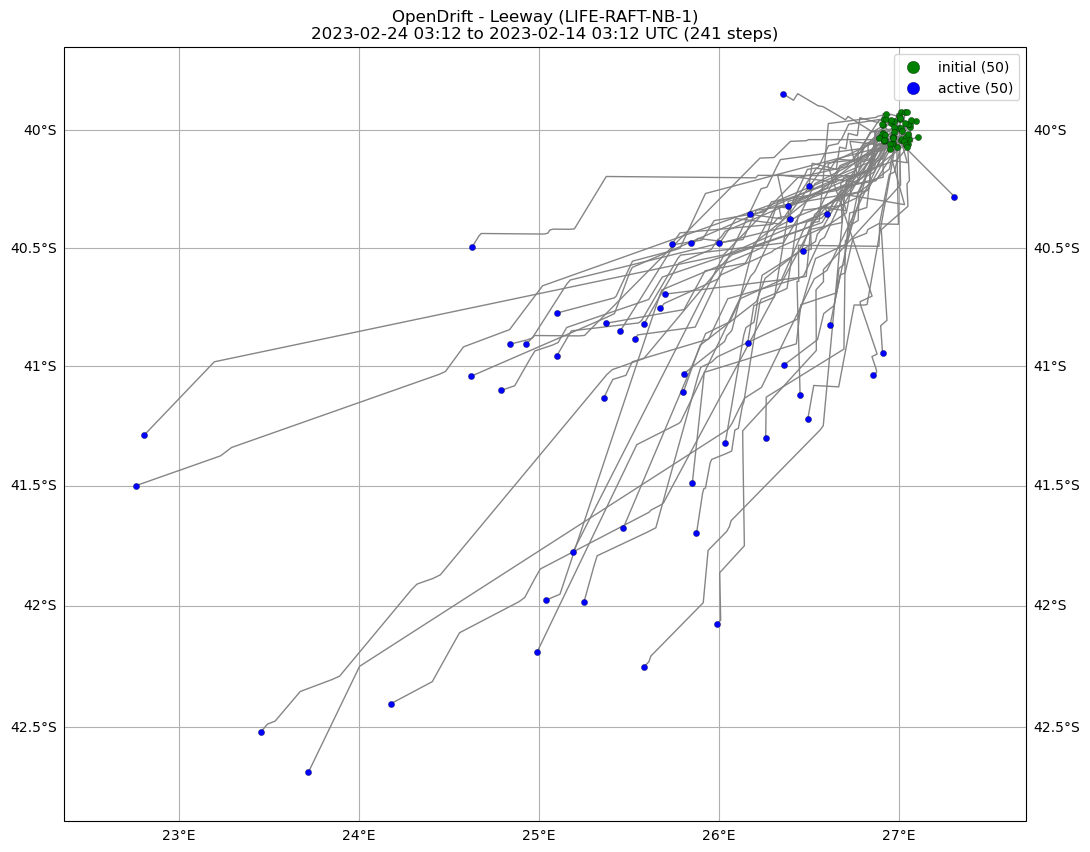

(<GeoAxes: title={'center': 'OpenDrift - Leeway (LIFE-RAFT-NB-1)\n2023-02-24 03:12 to 2023-02-14 03:12 UTC (241 steps)'}>,
 <Figure size 1100x887.593 with 1 Axes>)

In [139]:
orev0.plot()

In [140]:
caps = []
for i in range(len(bwd0.trajectory)): 
    caps.append(bwd0.isel(trajectory=i).capsized.values[-1])

In [143]:
# Set the desired grid size
grid_size_lon = 0.5  # Change this to your desired grid size
grid_size_lat = 0.5

# Calculate the number of grid cells in each dimension
lon_bins = np.arange(np.min(bwd0.isel(time=120).lon.values)-(0.5), np.max(bwd0.isel(time=120).lon.values)+(0.5), grid_size_lon)
lat_bins = np.arange(np.min(bwd0.isel(time=120).lat.values)-(0.5), np.max(bwd0.isel(time=120).lat.values)+(0.5), grid_size_lat)

In [144]:
binmesh = np.meshgrid(lon_bins, lat_bins)

In [145]:
lons = np.zeros((len(lon_bins)-1,(len(lat_bins)*200)-200))
lats = np.zeros((len(lon_bins)-1,(len(lat_bins)*200)-200))
for i in range(len(binmesh[0][0])-1):
    for j in range(len(binmesh[1])-1):
        lons[i][(j*200):((j+1)*200)] = np.random.uniform(binmesh[0][0][i], binmesh[0][0][i+1], 200) # Much coarser CCC
        lats[i][(j*200):((j+1)*200)] = np.random.uniform(binmesh[1][j][0], binmesh[1][j+1][0], 200)

# FWD

In [146]:
outfile = "D:/backtrack/oceandrift_48h/likelihood/lw_fwd_1424feb_raft_capsize_constwind_nocurrent_v1.nc"

In [147]:
# ofwd = Leeway(loglevel=0)
# ofwd.list_configspec()

In [148]:
ofwd = Leeway(loglevel=50)
# ofwd.add_reader([reader_globcur, reader_wind])
ofwd.set_config('drift:advection_scheme', 'runge-kutta4')

# ofwd.set_config('environment:fallback:x_sea_water_velocity', 0)
# ofwd.set_config('environment:fallback:y_sea_water_velocity', 0)

ofwd.set_config('environment:constant:x_wind', 5)
ofwd.set_config('environment:constant:y_wind', 5)
ofwd.set_config('environment:constant:x_sea_water_velocity', 0)
ofwd.set_config('environment:constant:y_sea_water_velocity', 0)

ofwd.set_config('capsizing', True)
ofwd.set_config('capsizing:wind_threshold', 20)
ofwd.set_config('capsizing:wind_threshold_sigma', 5)
ofwd.set_config('capsizing:leeway_fraction', 0.4)  # Reducing leeway coefficients to 40% of original after capsize

#ofwd.set_config('drift:horizontal_diffusivity', 20)
# ofwd.seed_elements(lon=27, lat=-40, radius=10000, number=15, time=start_time, object_type=object_type)
ofwd.seed_elements(lon=lons, lat=lats, radius=0, time=start_time, object_type=object_type)
ofwd.run(duration=duration, time_step=600, time_step_output=3600, outfile=outfile)

In [330]:
o_outfile = "D:/backtrack/oceandrift_48h/likelihood/lw_fwd_1424feb_raft_capsize_constwind_nocurrent_fallback_v1.nc"

In [331]:
o = Leeway(loglevel=50)
o.set_config('drift:advection_scheme', 'runge-kutta4')

o.set_config('environment:fallback:x_sea_water_velocity', 0)
o.set_config('environment:fallback:y_sea_water_velocity', 0)
o.set_config('environment:fallback:x_wind', 5)
o.set_config('environment:fallback:y_wind', 5)
# ofwd.set_config('environment:constant:x_sea_water_velocity', 0)
# ofwd.set_config('environment:constant:y_sea_water_velocity', 0)

o.set_config('capsizing', True)
o.set_config('capsizing:wind_threshold', 20)
o.set_config('capsizing:wind_threshold_sigma', 5)
o.set_config('capsizing:leeway_fraction', 0.4)  # Reducing leeway coefficients to 40% of original after capsize

#ofwd.set_config('drift:horizontal_diffusivity', 20)
o.seed_elements(lon=27, lat=-40, radius=10000, number=15, time=start_time, object_type=object_type)
# ofwd.seed_elements(lon=lons, lat=lats, radius=0, time=start_time, object_type=object_type)
o.run(duration=duration, time_step=600, time_step_output=3600, outfile=o_outfile)

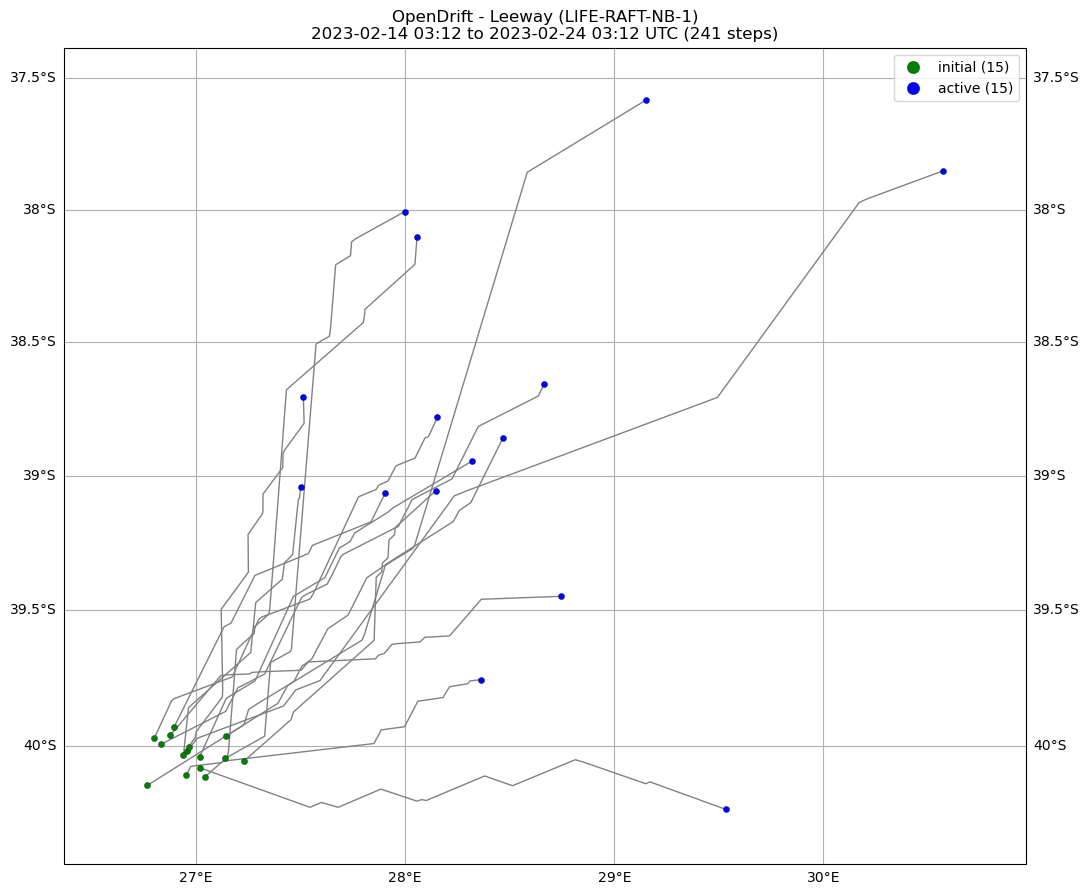

(<GeoAxes: title={'center': 'OpenDrift - Leeway (LIFE-RAFT-NB-1)\n2023-02-14 03:12 to 2023-02-24 03:12 UTC (241 steps)'}>,
 <Figure size 1100x936.489 with 1 Axes>)

In [332]:
o.plot()

In [149]:
fwd = xr.open_dataset(outfile)

In [150]:
len(fwd.trajectory)

6000

In [151]:
capsized = []
for i in range(len(fwd.trajectory)):
    capsized.append(fwd.isel(trajectory=i).capsized.values[-1])

In [152]:
np.count_nonzero(capsized)

4524

In [153]:
fwd.isel(trajectory=3).capsized.values

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

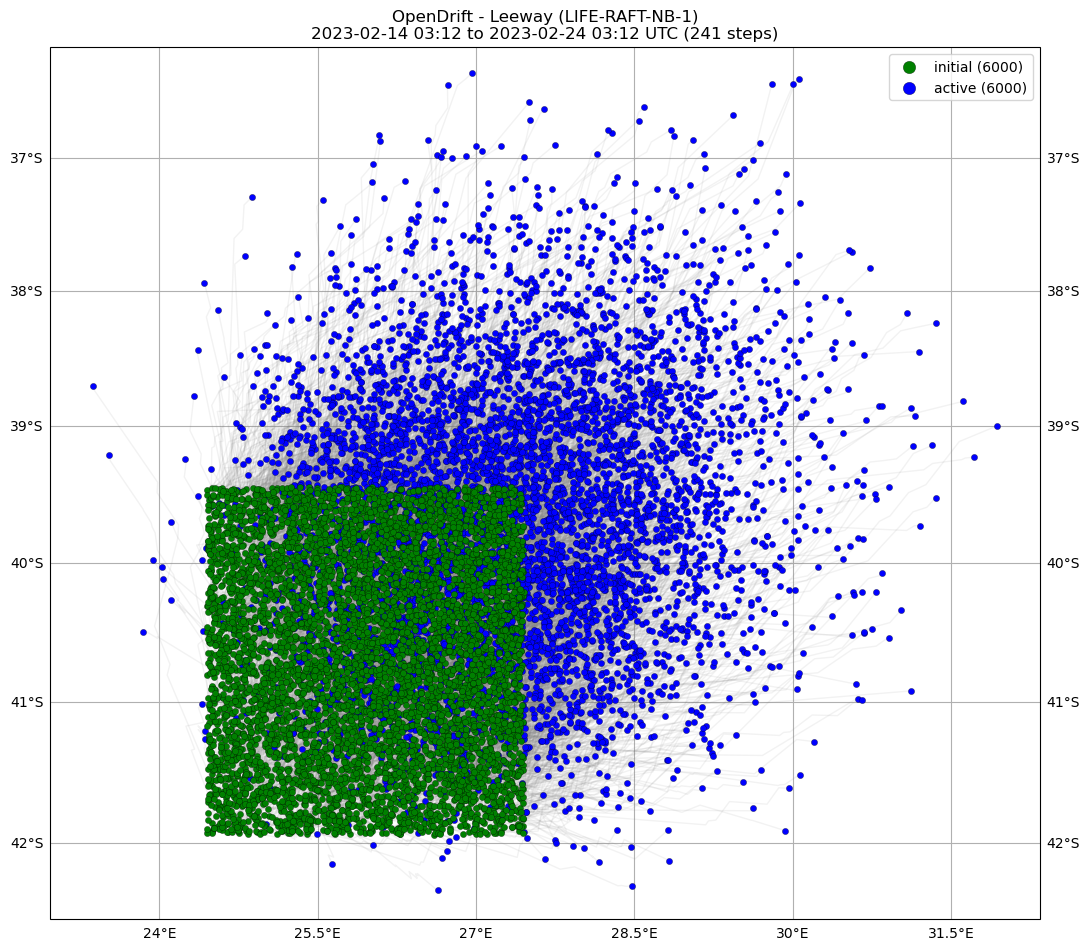

(<GeoAxes: title={'center': 'OpenDrift - Leeway (LIFE-RAFT-NB-1)\n2023-02-14 03:12 to 2023-02-24 03:12 UTC (241 steps)'}>,
 <Figure size 1100x968.663 with 1 Axes>)

In [154]:
from matplotlib.colors import ListedColormap
ofwd.plot(color='capsized', cmap=ListedColormap(['black','red']), fast=True)

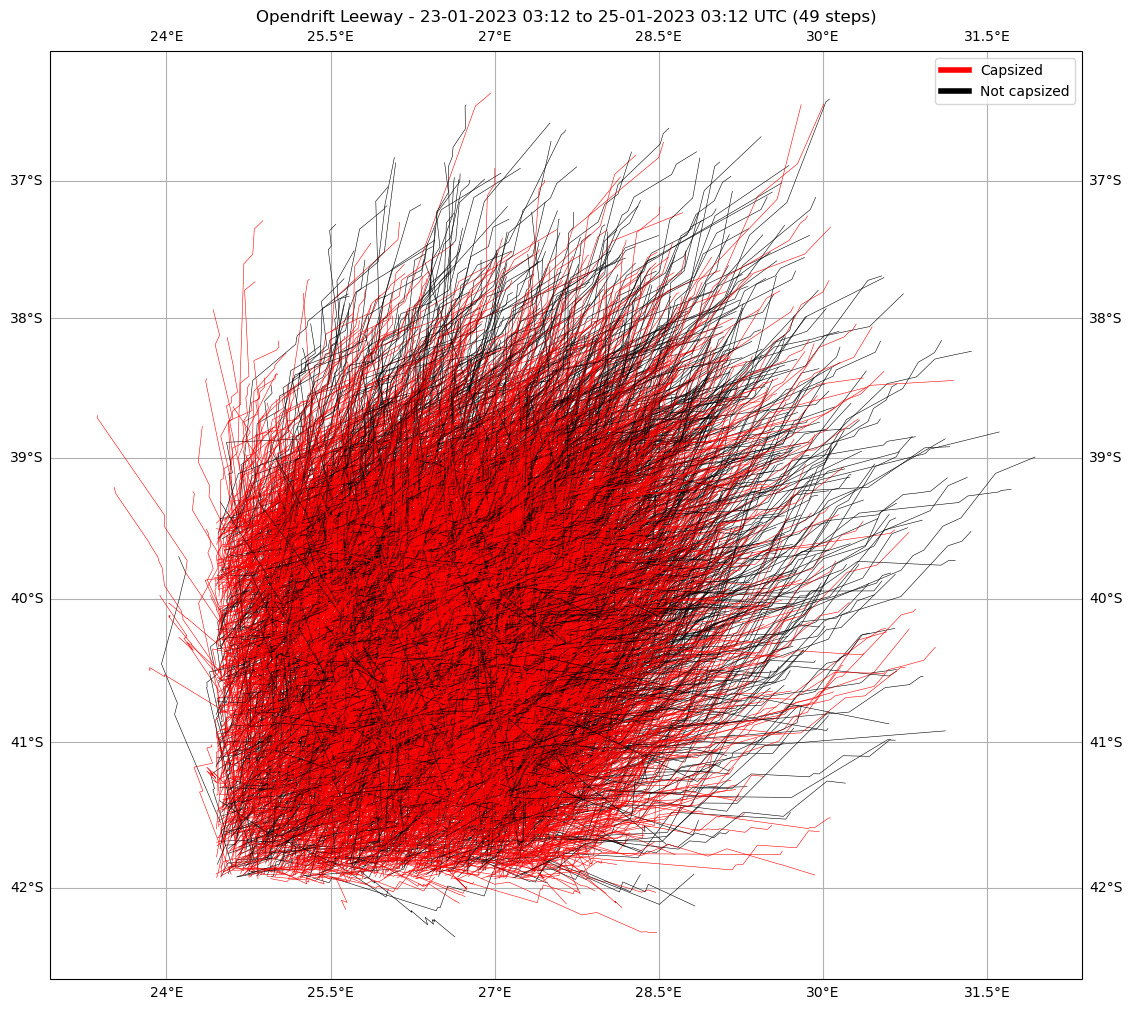

In [155]:
### PLOT ### 
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(projection=ccrs.Mercator())
ax.gridlines(draw_labels=True)

for i in range(len(fwd.trajectory)):
    if capsized[i]>0: 
        fwd.isel(trajectory=i).traj.plot(linewidth=0.4, color='red')
    else: 
        fwd.isel(trajectory=i).traj.plot(linewidth=0.4, color='black')
    
ccrs.Geodetic()

custom_lines = [#Line2D([0], [0], color='blue', lw=4),
                Line2D([0], [0], color='red', lw=4),
                #Line2D([0], [0], color='grey', lw=4),
                Line2D([0], [0], color='black', lw=4)]

ax.legend(custom_lines, ['Capsized', 'Not capsized'])

plt.gca().autoscale()
plt.title('Opendrift Leeway - 23-01-2023 03:12 to 25-01-2023 03:12 UTC (49 steps)')
plt.show()

In [156]:
## FORWARD ## 
lonend0 = []
latend0 = []
for j in range(len(fwd.trajectory)):
        lonend0.append(fwd.isel(trajectory=j).lon.values[-1])   # lon at end of trajectory
        latend0.append(fwd.isel(trajectory=j).lat.values[-1])   # lat at end of trajectory

## BACKWARDS

In [313]:
orev = Leeway(loglevel=50)

15:57:46 DEBUG   opendrift.config:161: Adding 10 config items from environment
15:57:46 DEBUG   opendrift.config:161: Adding 5 config items from environment


In [315]:
outfile_bwd = "D:/backtrack/oceandrift_48h/likelihood/lw_bwd_2325jan_raft_capsize_nocurrent_constwind_allbwd_v1.nc"

In [317]:
lonend1 = np.array(lonend0)
latend1 = np.array(latend0)

In [318]:
lonend = lonend1[~np.isnan(lonend0)]
latend = latend1[~np.isnan(latend0)]

In [319]:
orev = Leeway(loglevel=50)
# orev.add_reader([reader_globcur, reader_wind])

orev.set_config('drift:advection_scheme', 'runge-kutta4')
orev.set_config('environment:constant:x_wind', 5)
orev.set_config('environment:constant:y_wind', 5)
orev.set_config('environment:constant:x_sea_water_velocity', 0)
orev.set_config('environment:constant:y_sea_water_velocity', 0)

orev.set_config('capsizing', True)
orev.set_config('capsizing:wind_threshold', 20)
orev.set_config('capsizing:wind_threshold_sigma', 5)
orev.set_config('capsizing:leeway_fraction', 0.4)  # Reducing leeway coefficients to 40% of original after capsize

#orev.set_config('drift:horizontal_diffusivity', 20)
orev.seed_elements(lon=lonend, lat=latend, radius_type='uniform', time=end_time, object_type=object_type, capsized=1)
orev.run(duration=duration, time_step=-600, time_step_output=3600, outfile=outfile_bwd)

In [320]:
bwd = xr.open_dataset(outfile_bwd)

In [321]:
capsized_bwd = []
for i in range(len(bwd.trajectory)):
    capsized_bwd.append(bwd.isel(trajectory=i).capsized.values[-1])

In [322]:
np.count_nonzero(capsized_bwd)

1476

In [323]:
len(bwd.trajectory)

6000

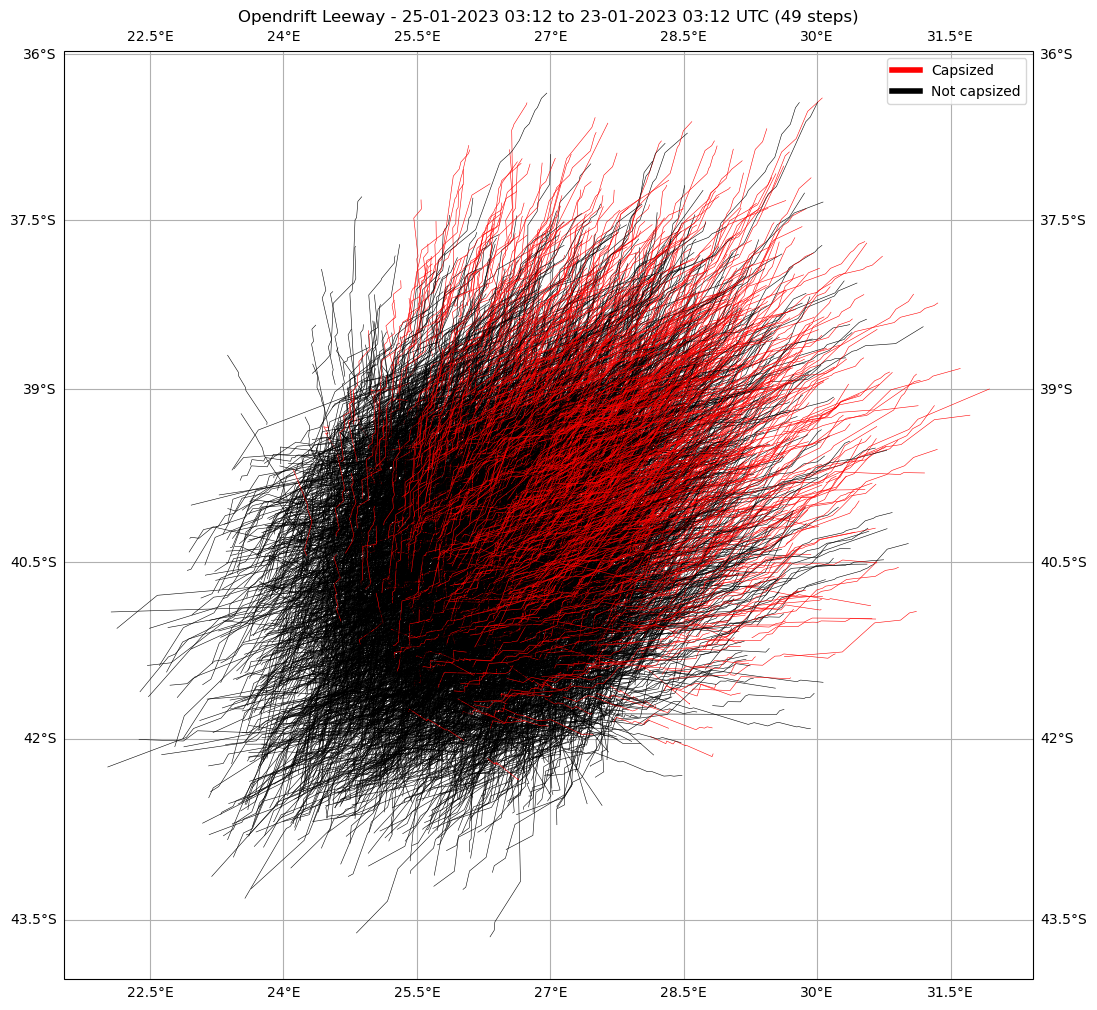

In [324]:
### PLOT ### 
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(projection=ccrs.Mercator())
ax.gridlines(draw_labels=True)

for i in range(len(bwd.trajectory)):
    if capsized_bwd[i]>0: 
        bwd.isel(trajectory=i).traj.plot(linewidth=0.4, color='red')
    else: 
        bwd.isel(trajectory=i).traj.plot(linewidth=0.4, color='black')
    
ccrs.Geodetic()

custom_lines = [#Line2D([0], [0], color='blue', lw=4),
                Line2D([0], [0], color='red', lw=4),
                #Line2D([0], [0], color='grey', lw=4),
                Line2D([0], [0], color='black', lw=4)]

ax.legend(custom_lines, ['Capsized', 'Not capsized'])

plt.gca().autoscale()
plt.title('Opendrift Leeway - 25-01-2023 03:12 to 23-01-2023 03:12 UTC (49 steps)')
plt.show()

## Comparison

No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimen

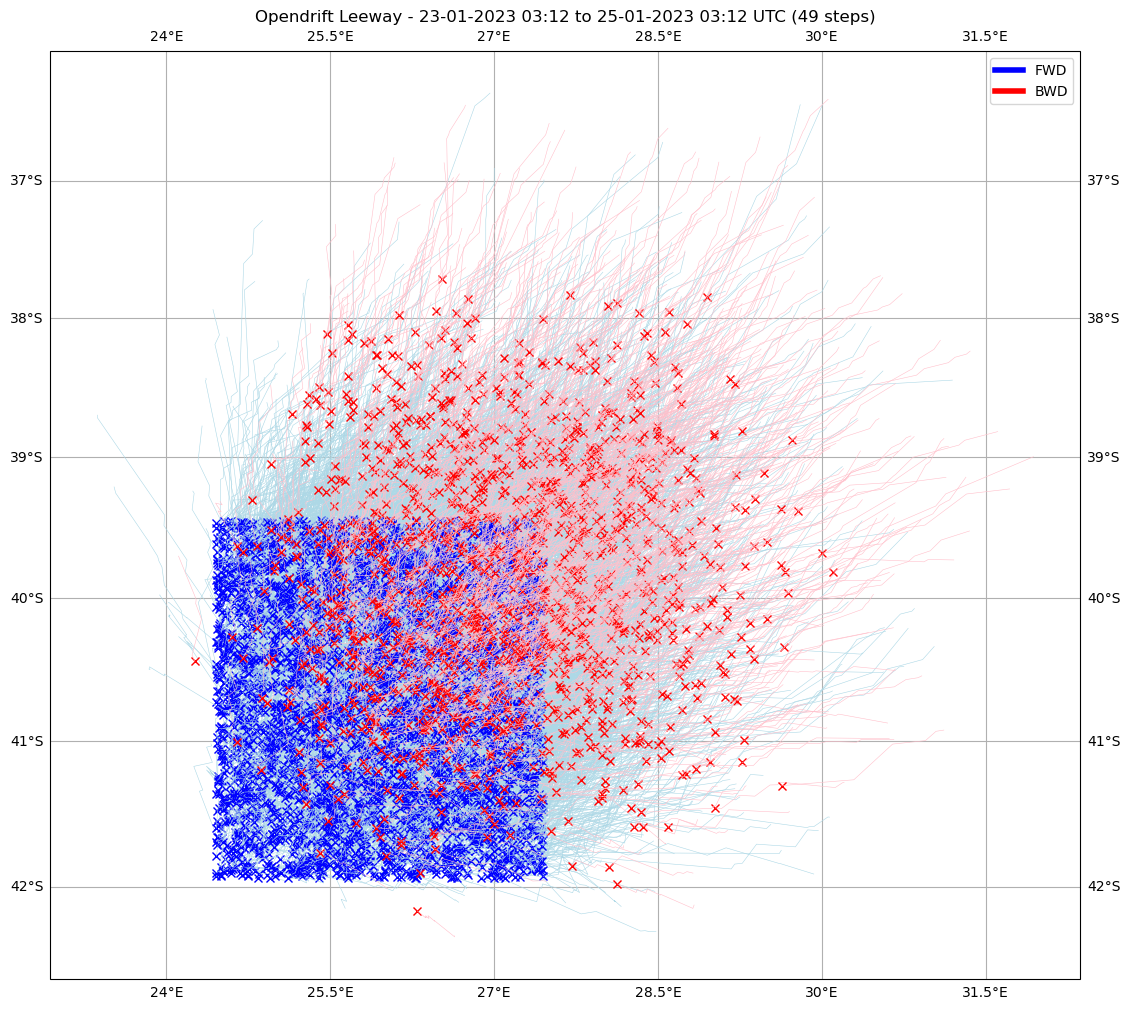

In [334]:
## PLOT ### 
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(projection=ccrs.Mercator())
ax.gridlines(draw_labels=True)

for i in range(len(fwd.trajectory)):
    if capsized[i]>0:
        fwd.isel(trajectory=i).isel(time=0).traj.plot(marker='x', color='blue')
        fwd.isel(trajectory=i).traj.plot(linewidth=0.4, color='lightblue')
        
for i in range(len(bwd.trajectory)):
    if capsized_bwd[i]>0: 
        bwd.isel(trajectory=i).isel(time=240).traj.plot(marker='x', color='red')
        bwd.isel(trajectory=i).traj.plot(linewidth=0.4, color='pink')
    
ccrs.Geodetic()

custom_lines = [Line2D([0], [0], color='blue', lw=4),
                Line2D([0], [0], color='red', lw=4),
                #Line2D([0], [0], color='grey', lw=4),
                #Line2D([0], [0], color='black', lw=4)
               ]

ax.legend(custom_lines, ['FWD', 'BWD'])

plt.gca().autoscale()
plt.title('Opendrift Leeway - 23-01-2023 03:12 to 25-01-2023 03:12 UTC (49 steps)')
plt.show()

In [167]:
### PLOT ### 
# fig = plt.figure(figsize=(12,10))
# ax = fig.add_subplot(projection=ccrs.Mercator())
# ax.gridlines(draw_labels=True)

# for i in range(len(fwd.trajectory)):
#     fwd.isel(trajectory=i).traj.plot(linewidth=0.4, color='blue')

# for i in range(len(bwd.trajectory)):
#     bwd.isel(trajectory=i).traj.plot(linewidth=0.4, color='red')
    
# ccrs.Geodetic()

# custom_lines = [Line2D([0], [0], color='blue', lw=4),
#                 Line2D([0], [0], color='red', lw=4),
#                 #Line2D([0], [0], color='grey', lw=4),
#                 #Line2D([0], [0], color='black', lw=4)
#                ]

# ax.legend(custom_lines, ['FWD', 'BWD'])

# plt.gca().autoscale()
# plt.title('Opendrift Leeway - 23-01-2023 03:12 to 25-01-2023 03:12 UTC (49 steps)')
# plt.show()

In [168]:
# ### PLOT ### 
# fig = plt.figure(figsize=(12,10))
# ax = fig.add_subplot(projection=ccrs.Mercator())
# ax.gridlines(draw_labels=True)

# for i in range(len(fwd.trajectory)):
#     fwd.isel(trajectory=i).isel(time=0).traj.plot(linewidth=0.4, color='blue', marker='o')
#     fwd.isel(trajectory=i).isel(time=48).traj.plot(linewidth=0.4, color='lightblue', marker='o')

# for i in range(len(bwd.trajectory)):
#     bwd.isel(trajectory=i).isel(time=48).traj.plot(linewidth=0.4, color='red', marker='o')
#     bwd.isel(trajectory=i).isel(time=0).traj.plot(linewidth=0.4, color='pink', marker='o')
    
# ccrs.Geodetic()

# custom_lines = [Line2D([0], [0], color='blue', lw=4),
#                 Line2D([0], [0], color='red', lw=4),
#                 #Line2D([0], [0], color='grey', lw=4),
#                 #Line2D([0], [0], color='black', lw=4)
#                ]

# ax.legend(custom_lines, ['FWD', 'BWD'])

# plt.gca().autoscale()
# plt.title('Opendrift Leeway - 23-01-2023 03:12 to 25-01-2023 03:12 UTC (49 steps)')
# plt.show()

## Picking one as 'truth'

In [253]:
n = []
ilon = []
ilat = []
startlon = []
startlat = []
a_traj = []

traj = np.arange(0,len(fwd.trajectory),1)

for i in range(1):
    a = np.random.choice(traj)
    a_traj.append(a)
    iloni = fwd.isel(trajectory=a).lon.values[-1]
    ilon.append(iloni)
    ilati = fwd.isel(trajectory=a).lat.values[-1]
    ilat.append(ilati)
    startloni = fwd.isel(trajectory=a).lon.values[0]
    startlon.append(startloni)
    startlati = fwd.isel(trajectory=a).lat.values[0]
    startlat.append(startlati)
    if iloni<1e10 and ilati<1e10:
        geod = pyproj.Geod(ellps='WGS84')
        on = np.ones(len(lonend0))
        dummy1, dummy2, dist2incident = geod.inv(lonend0, latend0, iloni*on, ilati*on)
        hits = pd.DataFrame(np.where(dist2incident<10000))
        lenhits = hits.shape[1]
        n.append(lenhits) 
        
        hit_start_lons = []
        hit_start_lats = []
        for m in range(lenhits):
            hit_start_lons.append(fwd.isel(trajectory=hits[m]).lon.values[-1][0])
            hit_start_lats.append(fwd.isel(trajectory=hits[m]).lat.values[-1][0])

In [254]:
fwd.isel(trajectory=a).capsized.values

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [255]:
hits.values[0]

array([  37,   72,  407, 1126, 1633, 1950, 2526, 2656, 2689, 2772, 2782,
       2930, 2957, 3346, 3427, 3466, 3676, 3692, 3875, 3930, 4551, 4726,
       4985], dtype=int64)

In [256]:
xfwd = fwd.isel(trajectory=hits.values[0])

In [257]:
capsized_xfwd = []
for i in range(len(xfwd.trajectory)):
    capsized_xfwd.append(xfwd.isel(trajectory=i).capsized.values[-1])

In [258]:
np.count_nonzero(capsized_xfwd)

16

In [259]:
len(xfwd.trajectory)

23

In [260]:
xlon = []       # lon for 'hits'
xlat = []       # lat for 'hits'

for i in range(len(xfwd.trajectory)):
    xlon.append(xfwd.isel(trajectory=i).lon.values[0])
    xlat.append(xfwd.isel(trajectory=i).lat.values[0])

In [293]:
def count_points_in_grid(lon, lat, lonbins, latbins):
    
    lobi = []
    labi = []
    for i in range(len(lonbins)-1):
        lobi.append((lonbins[i]+lonbins[i+1])/2)
    for i in range(len(latbins)-1):
        labi.append((latbins[i]+latbins[i+1])/2)
        
    # Count the number of points in each grid cell
    counts, xedges, yedges = np.histogram2d(lon, lat, bins=[lonbins, latbins])
    
    # Create a new DataArray with the counts and assign coordinates
    counts_dataarray = xr.DataArray(counts, coords=[('lon_bin', lobi), ('lat_bin', labi)])
    
    return counts_dataarray 

# Call the function to count points in grid cells
grid_counts = count_points_in_grid(xlon, xlat, xlon_bins, xlat_bins)

In [294]:
o_hit = opendrift.open(outfile, elements=hits.values[0])

15:44:07 DEBUG   opendrift.config:161: Adding 10 config items from environment
15:44:07 DEBUG   opendrift.config:161: Adding 5 config items from environment
15:44:08 DEBUG   opendrift.config:161: Adding 16 config items from __init__
15:44:08 DEBUG   opendrift.config:171:   Overwriting config item readers:max_number_of_fails
15:44:08 DEBUG   opendrift.config:161: Adding 5 config items from __init__
15:44:08 INFO    opendrift.models.basemodel:533: OpenDriftSimulation initialised (version 1.11.2 / v1.11.2-43-gce9f6bb)
15:44:08 DEBUG   opendrift.config:161: Adding 6 config items from leeway
15:44:08 DEBUG   opendrift.config:171:   Overwriting config item seed:jibe_probability
15:44:08 DEBUG   opendrift.export.io_netcdf:281: Importing from D:/backtrack/oceandrift_48h/likelihood/lw_fwd_1424feb_raft_capsize_constwind_nocurrent_v1.nc
15:44:09 DEBUG   opendrift.models.basemodel:1683: No elements to deactivate
15:44:09 DEBUG   opendrift.export.io_netcdf:380: Setting imported config: environment:

15:44:11 DEBUG   opendrift.models.basemodel:2333: Setting up map: corners=None, fast=False, lscale=None
15:44:11 DEBUG   opendrift.readers.reader_global_landmask:83: Adding GSHHG shapes from cartopy, scale: i, extent: (24.160131072998052, 27.569336318969725, -42.00389404296875, -39.08231048583985)..
15:44:12 DEBUG   opendrift.readers.reader_global_landmask:83: Adding GSHHG shapes from cartopy, scale: i, extent: (24.160131072998052, 27.569336318969725, -42.00389404296875, -39.08231048583985)..
15:44:13 DEBUG   opendrift.readers.reader_global_landmask:83: Adding GSHHG shapes from cartopy, scale: i, extent: (24.160131072998052, 27.569336318969725, -42.00389404296875, -39.08231048583985)..


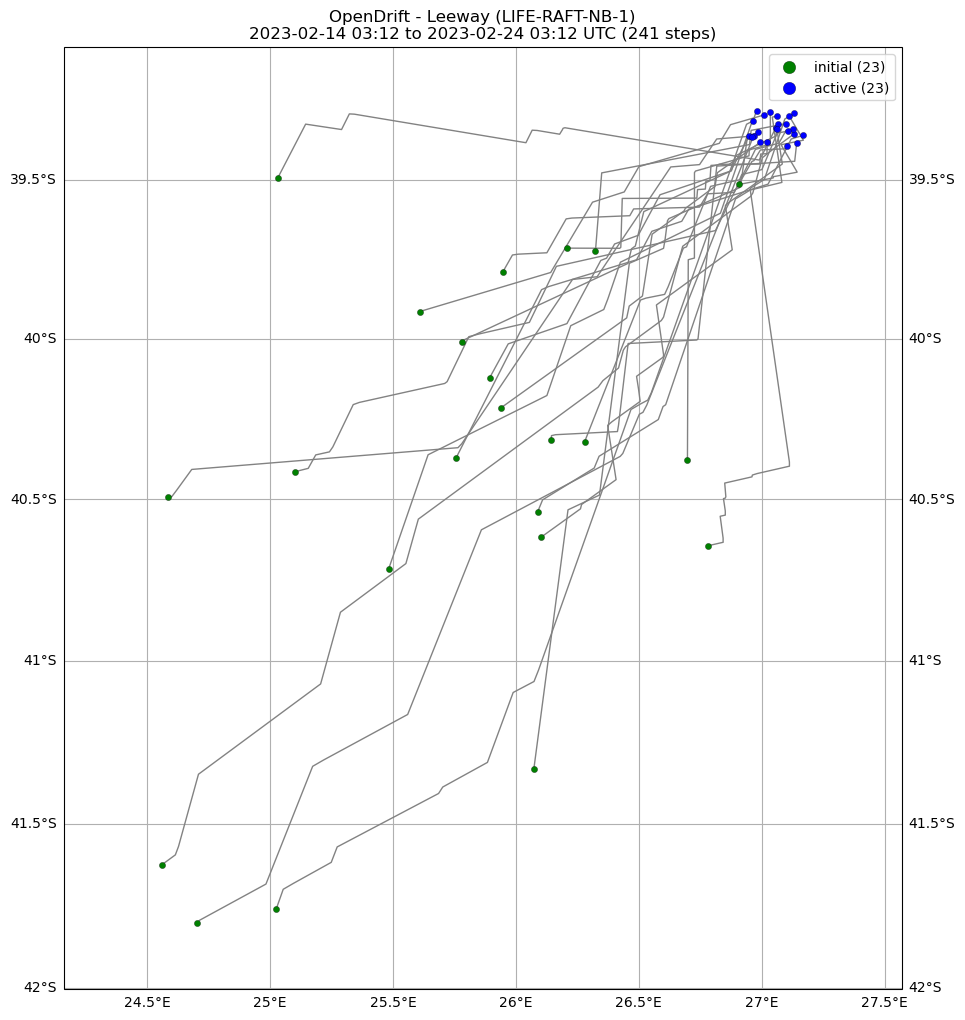

(<GeoAxes: title={'center': 'OpenDrift - Leeway (LIFE-RAFT-NB-1)\n2023-02-14 03:12 to 2023-02-24 03:12 UTC (241 steps)'}>,
 <Figure size 975.425x1100 with 1 Axes>)

In [295]:
o_hit.plot()

15:44:14 DEBUG   opendrift.models.basemodel:2333: Setting up map: corners=None, fast=True, lscale=None
15:44:14 WARNING opendrift.models.basemodel:2379: Plotting fast. This will make your plots less accurate.


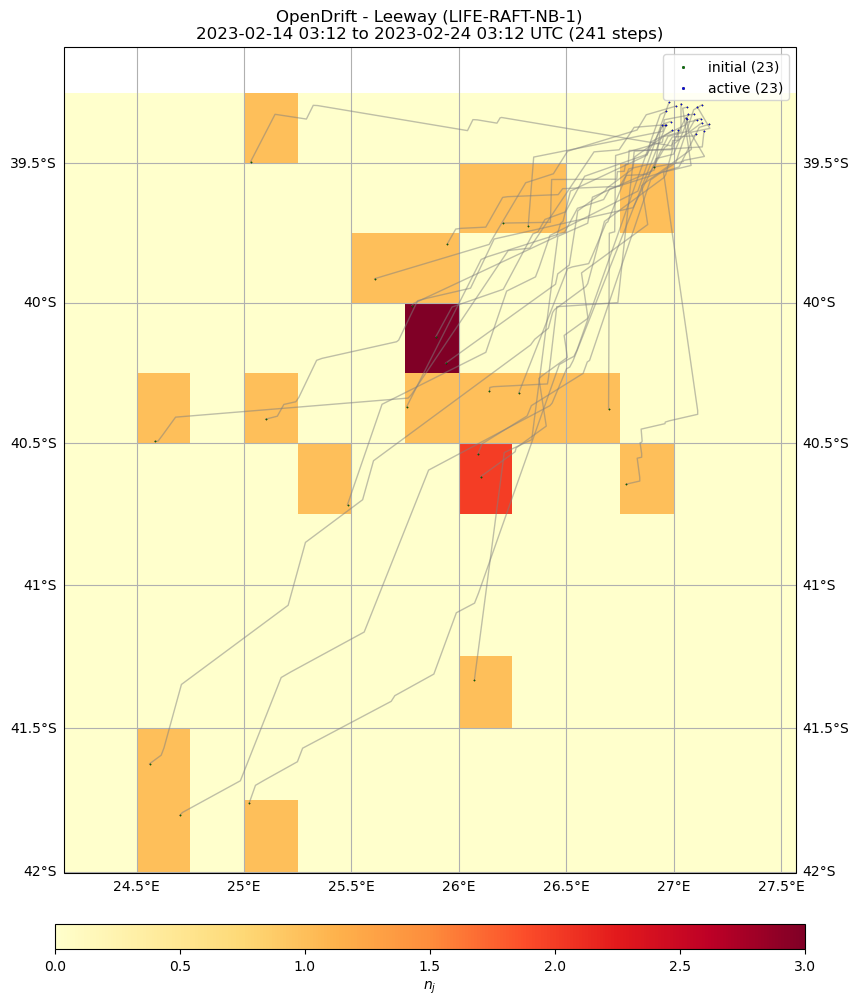

(<GeoAxes: title={'center': 'OpenDrift - Leeway (LIFE-RAFT-NB-1)\n2023-02-14 03:12 to 2023-02-24 03:12 UTC (241 steps)'}>,
 <Figure size 975.425x1100 with 2 Axes>)

In [296]:
o_hit.plot(background=grid_counts, clabel='$n_j$', fast=True, markersize=1, lalpha=.5, cmap='YlOrRd')

In [266]:
outfile_bwd_truth = "D:/backtrack/oceandrift_48h/likelihood/lw_bwd_1424feb_raft_capsize_constwind_nocurrent_v1.nc"

In [267]:
orev1 = Leeway(loglevel=50)

15:37:45 DEBUG   opendrift.config:161: Adding 10 config items from environment
15:37:45 DEBUG   opendrift.config:161: Adding 5 config items from environment


In [268]:
orev1 = Leeway(loglevel=50)
# orev1.add_reader([reader_globcur, reader_wind])

orev1.set_config('drift:advection_scheme', 'runge-kutta4')
orev1.set_config('environment:constant:x_wind', 5)
orev1.set_config('environment:constant:y_wind', 5)
orev1.set_config('environment:constant:x_sea_water_velocity', 0)
orev1.set_config('environment:constant:y_sea_water_velocity', 0)

orev1.set_config('capsizing', True)
orev1.set_config('capsizing:wind_threshold', 20)
orev1.set_config('capsizing:wind_threshold_sigma', 5)
orev1.set_config('capsizing:leeway_fraction', 0.4)  # Reducing leeway coefficients to 40% of original after capsize

#orev.set_config('drift:horizontal_diffusivity', 20)
orev1.seed_elements(lon=ilon, lat=ilat, radius=10000, radius_type='uniform', number=len(hits.values[0]), time=end_time, object_type=object_type, capsized=1)
orev1.run(duration=duration, time_step=-600, time_step_output=3600, outfile=outfile_bwd_truth)

In [269]:
bwd_truth = xr.open_dataset(outfile_bwd_truth)

In [270]:
capsized_bwd_truth = []
for i in range(len(bwd_truth.trajectory)):
    capsized_bwd_truth.append(bwd_truth.isel(trajectory=i).capsized.values[-1])

In [271]:
np.count_nonzero(capsized_bwd_truth)

8

In [272]:
len(bwd_truth.trajectory)

23

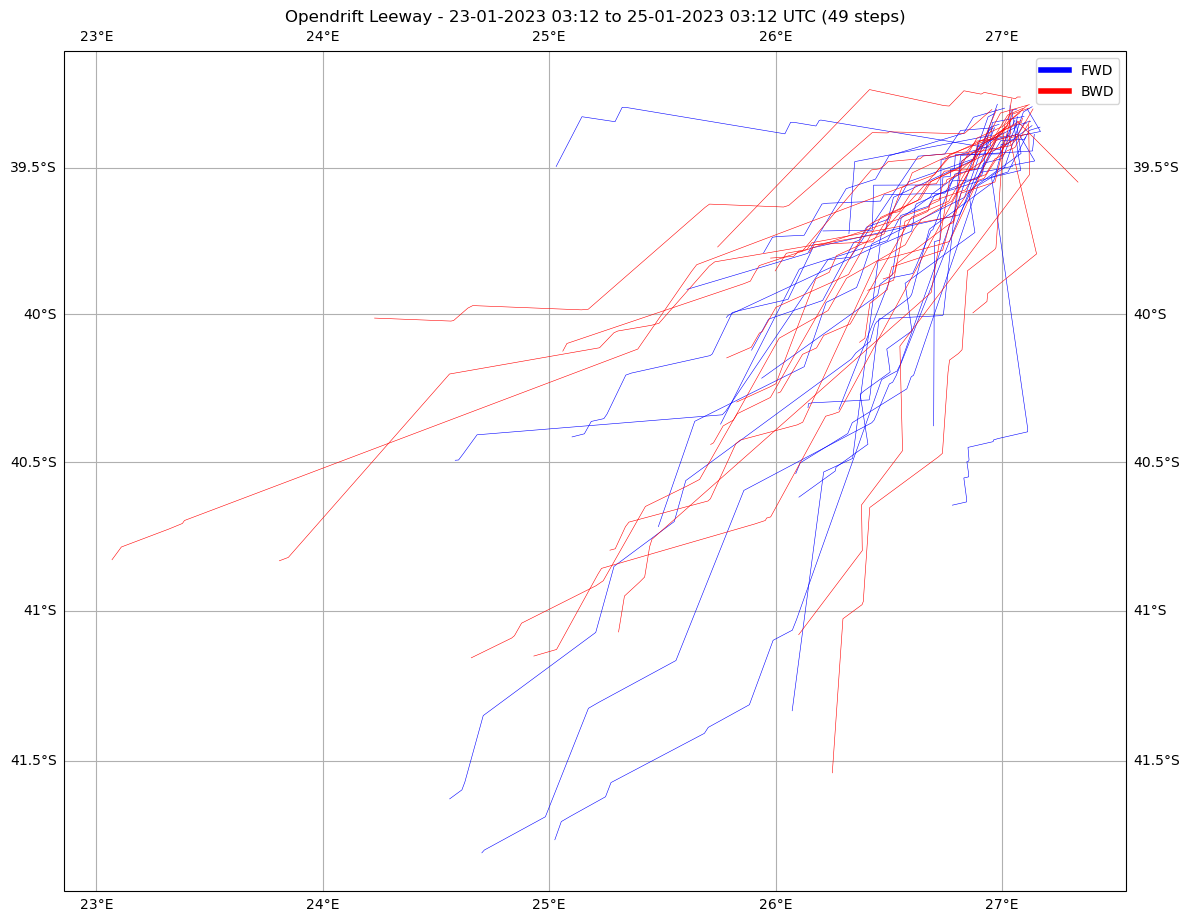

In [273]:
### PLOT ### 
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(projection=ccrs.Mercator())
ax.gridlines(draw_labels=True)

for i in range(len(xfwd.trajectory)):
    xfwd.isel(trajectory=i).traj.plot(linewidth=0.4, color='blue')

for i in range(len(bwd_truth.trajectory)):
    bwd_truth.isel(trajectory=i).traj.plot(linewidth=0.4, color='red')
    
ccrs.Geodetic()

custom_lines = [Line2D([0], [0], color='blue', lw=4),
                Line2D([0], [0], color='red', lw=4),
                #Line2D([0], [0], color='grey', lw=4),
                #Line2D([0], [0], color='black', lw=4)
               ]

ax.legend(custom_lines, ['FWD', 'BWD'])

plt.gca().autoscale()
plt.title('Opendrift Leeway - 23-01-2023 03:12 to 25-01-2023 03:12 UTC (49 steps)')
plt.show()

In [274]:
lonback = []       # lon for bwd
latback = []       # lat for bwd

for i in range(len(bwd_truth.trajectory)):
    lonback.append(bwd_truth.isel(trajectory=i).lon.values[-1])
    latback.append(bwd_truth.isel(trajectory=i).lat.values[-1])

In [287]:
### EXTENDED GRID ###

# Set the desired grid size
xgrid_size_lon = 0.25  # Change this to your desired grid size
xgrid_size_lat = 0.25

# Calculate the number of grid cells in each dimension
xlon_bins = np.arange(23,28, xgrid_size_lon)
xlat_bins = np.arange(-42, -39, xgrid_size_lat)

In [288]:
grid_counts_back = count_points_in_grid(lonback, latback, xlon_bins, xlat_bins)

In [289]:
o_back = opendrift.open(outfile_bwd_truth)

15:43:24 DEBUG   opendrift.config:161: Adding 10 config items from environment
15:43:24 DEBUG   opendrift.config:161: Adding 5 config items from environment
15:43:24 DEBUG   opendrift.config:161: Adding 16 config items from __init__
15:43:24 DEBUG   opendrift.config:171:   Overwriting config item readers:max_number_of_fails
15:43:24 DEBUG   opendrift.config:161: Adding 5 config items from __init__
15:43:24 INFO    opendrift.models.basemodel:533: OpenDriftSimulation initialised (version 1.11.2 / v1.11.2-43-gce9f6bb)
15:43:24 DEBUG   opendrift.config:161: Adding 6 config items from leeway
15:43:24 DEBUG   opendrift.config:171:   Overwriting config item seed:jibe_probability
15:43:24 DEBUG   opendrift.export.io_netcdf:281: Importing from D:/backtrack/oceandrift_48h/likelihood/lw_bwd_1424feb_raft_capsize_constwind_nocurrent_v1.nc
15:43:24 DEBUG   opendrift.models.basemodel:1683: No elements to deactivate
15:43:24 DEBUG   opendrift.export.io_netcdf:380: Setting imported config: environment:

15:43:24 DEBUG   opendrift.models.basemodel:2333: Setting up map: corners=None, fast=True, lscale=None
15:43:24 WARNING opendrift.models.basemodel:2379: Plotting fast. This will make your plots less accurate.


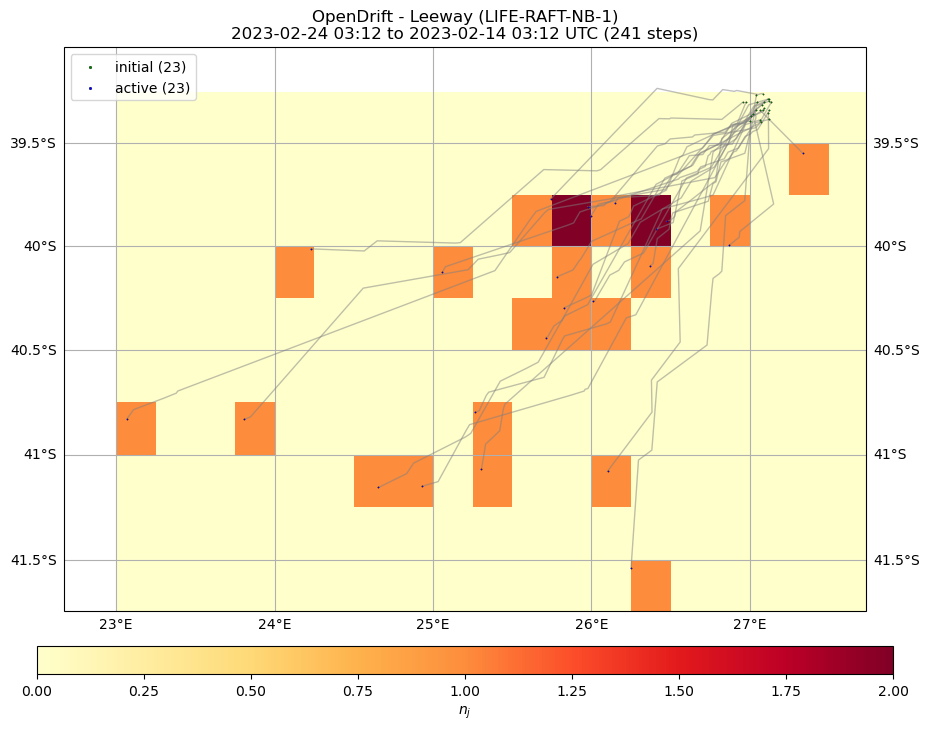

(<GeoAxes: title={'center': 'OpenDrift - Leeway (LIFE-RAFT-NB-1)\n2023-02-24 03:12 to 2023-02-14 03:12 UTC (241 steps)'}>,
 <Figure size 1100x772.082 with 2 Axes>)

In [290]:
o_back.plot(background=grid_counts_back, clabel='$n_j$', fast=True, markersize=1, lalpha=.5, vmin=0, cmap='YlOrRd')

In [291]:
grid_counts_back-grid_counts

<xarray.DataArray (lon_bin: 0, lat_bin: 0)> Size: 0B
array([], shape=(0, 0), dtype=float64)
Coordinates:
  * lon_bin  (lon_bin) float64 0B 
  * lat_bin  (lat_bin) float64 0B

15:44:40 DEBUG   opendrift.models.basemodel:2333: Setting up map: corners=None, fast=True, lscale=None
15:44:40 WARNING opendrift.models.basemodel:2379: Plotting fast. This will make your plots less accurate.


<Figure size 640x480 with 0 Axes>

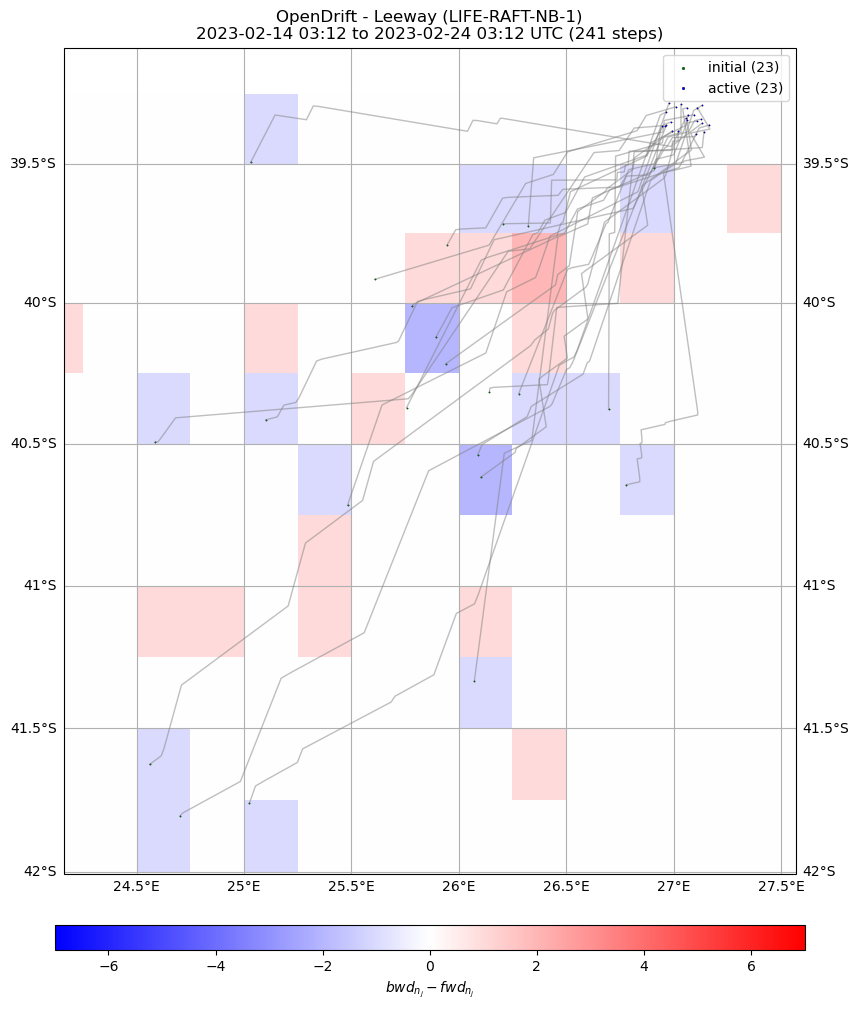

<Figure size 640x480 with 0 Axes>

In [297]:
plt.figure()

o_hit.plot(background=grid_counts_back-grid_counts, clabel='$bwd_{n_j} - fwd_{n_j}$', cmap='bwr', fast=True, markersize=1, lalpha=.5, vmin=-7, vmax=7)

plt.savefig('dif.png') 

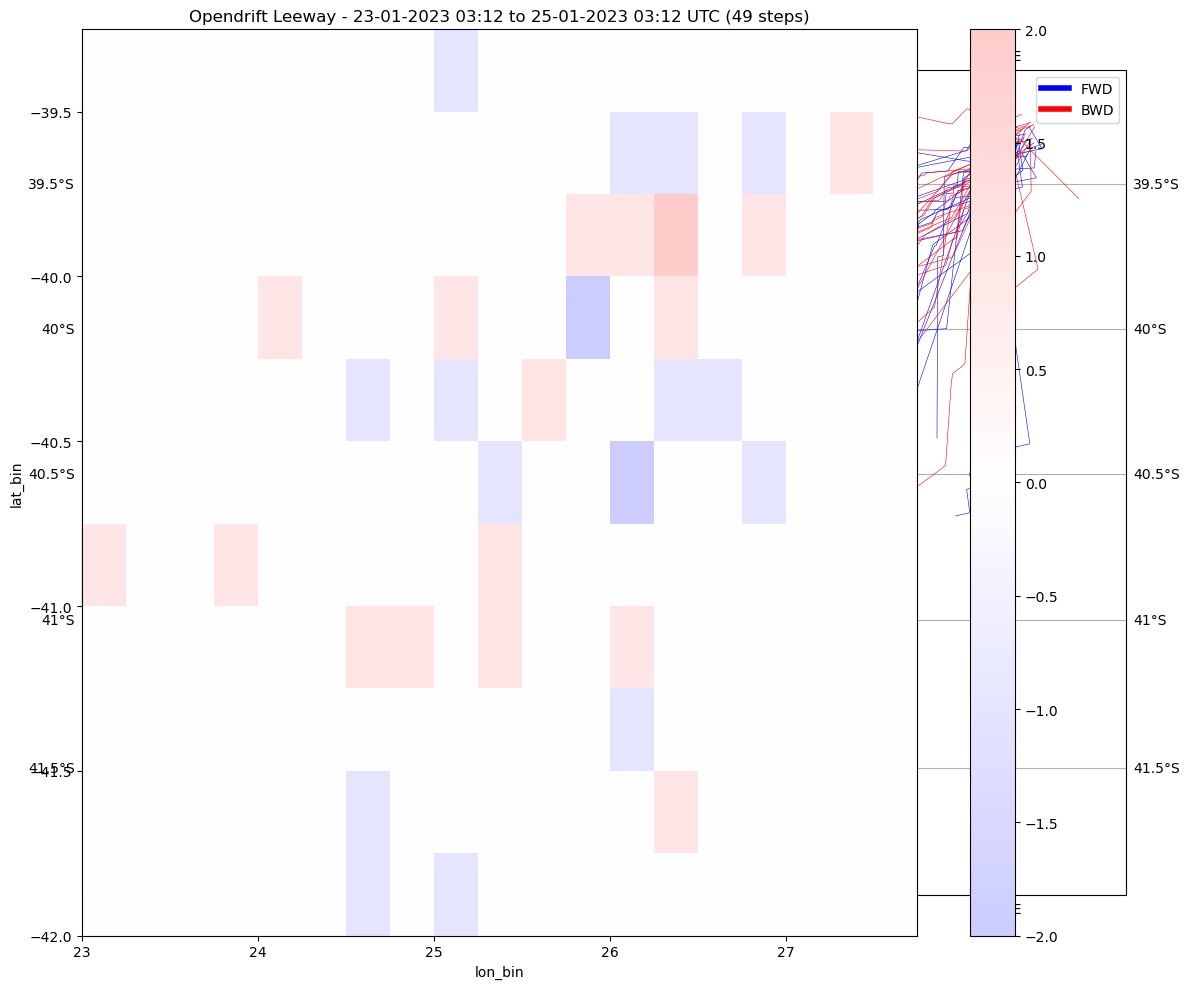

In [300]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(projection=ccrs.Mercator())
ax.gridlines(draw_labels=True)

for i in range(len(xfwd.trajectory)):
    xfwd.isel(trajectory=i).traj.plot(linewidth=0.4, color='blue')

for i in range(len(bwd_truth.trajectory)):
    bwd_truth.isel(trajectory=i).traj.plot(linewidth=0.4, color='red')


ax1 = fig.add_subplot()
dif.plot(x=grid_counts_back.dims[0], y=grid_counts_back.dims[1],cmap='bwr', alpha=.2)

ccrs.Geodetic()

custom_lines = [Line2D([0], [0], color='blue', lw=4),
                Line2D([0], [0], color='red', lw=4),
                #Line2D([0], [0], color='grey', lw=4),
                #Line2D([0], [0], color='black', lw=4)
               ]

ax.legend(custom_lines, ['FWD', 'BWD'])

plt.gca().autoscale()
plt.title('Opendrift Leeway - 23-01-2023 03:12 to 25-01-2023 03:12 UTC (49 steps)')
plt.show()

In [299]:
dif = grid_counts_back-grid_counts

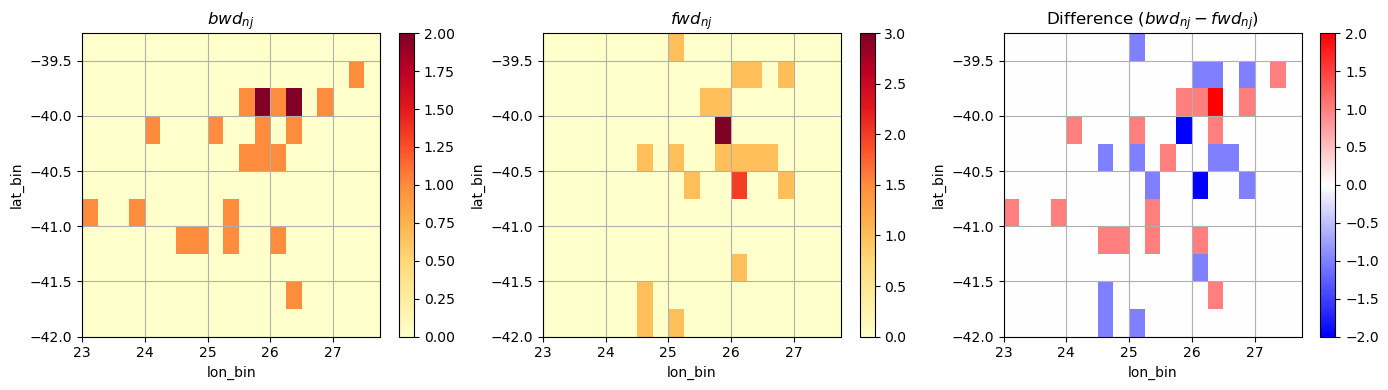

In [301]:
plt.figure(figsize=(14,4))

plt.subplot(1,3,1)
grid_counts_back.plot(x=grid_counts_back.dims[0], y=grid_counts_back.dims[1], cmap='YlOrRd')
plt.title('$bwd_{nj}$')
plt.grid()

plt.subplot(1,3,2)
grid_counts.plot(x=grid_counts.dims[0], y=grid_counts.dims[1], cmap='YlOrRd')
plt.title('$fwd_{nj}$')
plt.grid()

plt.subplot(1,3,3)
dif.plot(x=grid_counts_back.dims[0], y=grid_counts_back.dims[1], cmap='bwr')
plt.title('Difference $(bwd_{nj}-fwd_{nj})$')
plt.grid()

# plt.savefig('drieluik.png') 

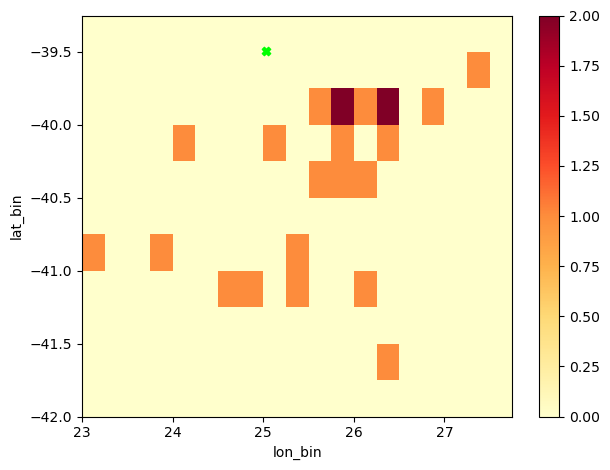

In [302]:
grid_counts_back.plot(x=grid_counts_back.dims[0], y=grid_counts_back.dims[1], cmap='YlOrRd')
plt.scatter(fwd.isel(trajectory=a).isel(time=0).lon.values, fwd.isel(trajectory=a).isel(time=0).lat.values, marker='X', color='lime')

In [303]:
fwd.isel(trajectory=a).isel(time=0).lon.values

array(25.030329, dtype=float32)

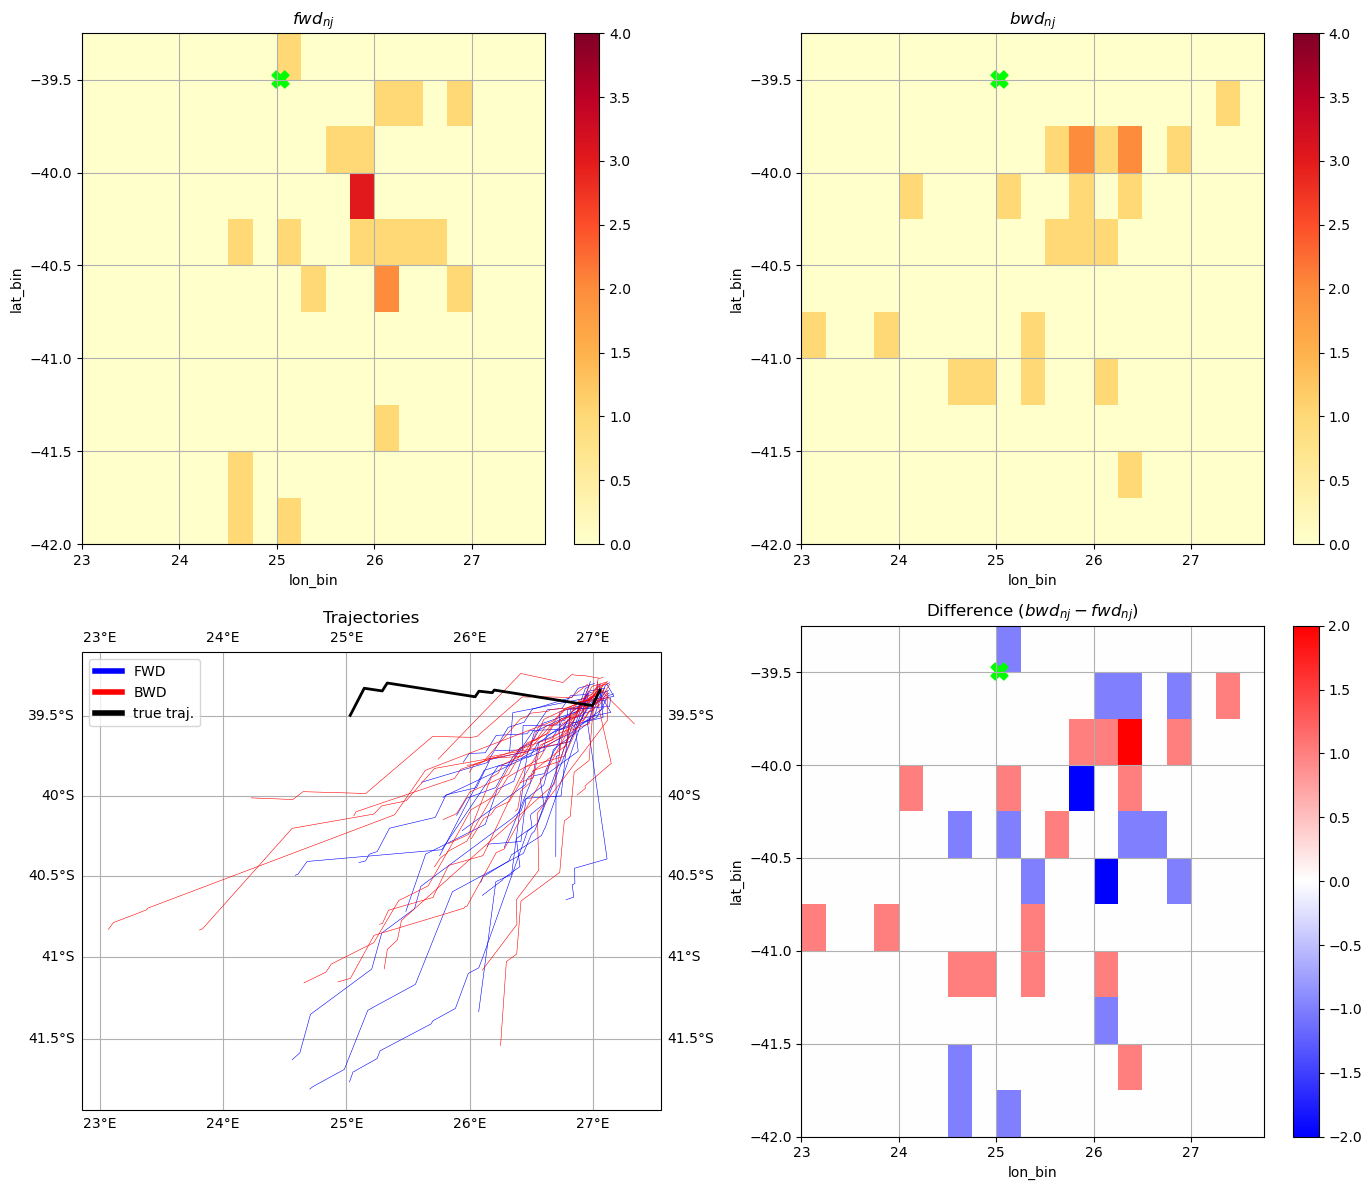

In [304]:
fig = plt.figure(figsize=(14,12))
size=150

plt.subplot(2,2,2)
grid_counts_back.plot(x=grid_counts_back.dims[0], y=grid_counts_back.dims[1], vmax=4, cmap='YlOrRd')
plt.scatter(fwd.isel(trajectory=a).isel(time=0).lon.values, fwd.isel(trajectory=a).isel(time=0).lat.values, size, marker='X', color='lime')
plt.title('$bwd_{nj}$')
plt.grid()

plt.subplot(2,2,1)
grid_counts.plot(x=grid_counts.dims[0], y=grid_counts.dims[1], vmax=4, cmap='YlOrRd')
plt.scatter(fwd.isel(trajectory=a).isel(time=0).lon.values, fwd.isel(trajectory=a).isel(time=0).lat.values, size, marker='X', color='lime')
plt.title('$fwd_{nj}$')
plt.grid()

plt.subplot(2,2,4)
dif.plot(x=grid_counts_back.dims[0], y=grid_counts_back.dims[1], cmap='bwr')
plt.scatter(fwd.isel(trajectory=a).isel(time=0).lon.values, fwd.isel(trajectory=a).isel(time=0).lat.values, size, marker='X', color='lime')
plt.title('Difference $(bwd_{nj}-fwd_{nj})$')
plt.grid()

# plt.subplot(2,2,3)
ax = fig.add_subplot(223, projection=ccrs.Mercator())
ax.gridlines(draw_labels=True)

for i in range(len(xfwd.trajectory)):
    xfwd.isel(trajectory=i).traj.plot(linewidth=0.4, color='blue')
    # if capsized_xfwd[i]<1:
    #     xfwd.isel(trajectory=i).traj.plot(linewidth=0.4, color='blue')
    # else: 
    #     xfwd.isel(trajectory=i).traj.plot(linewidth=1, linestyle='--', color='blue')

for i in range(len(bwd_truth.trajectory)):
    bwd_truth.isel(trajectory=i).traj.plot(linewidth=0.4, color='red')
    # if capsized_bwd_truth[i]>0: 
    #     bwd_truth.isel(trajectory=i).traj.plot(linewidth=1, linestyle='--', color='red')
    # else: 
    #     bwd_truth.isel(trajectory=i).traj.plot(linewidth=0.4, color='red')
        
fwd.isel(trajectory=a).traj.plot(color='black', linewidth=2)

custom_lines = [Line2D([0], [0], color='blue', lw=4),
                Line2D([0], [0], color='red', lw=4),
                #Line2D([0], [0], color='grey', lw=4),
                Line2D([0], [0], color='black', lw=4)
               ]

ax.legend(custom_lines, ['FWD', 'BWD', 'true traj.'])

# plt.gca().autoscale()
plt.title('Trajectories')

plt.savefig('vierluik_1424feb_threshold25.png') 
plt.show()

No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimension detected.
No time or obs dimen

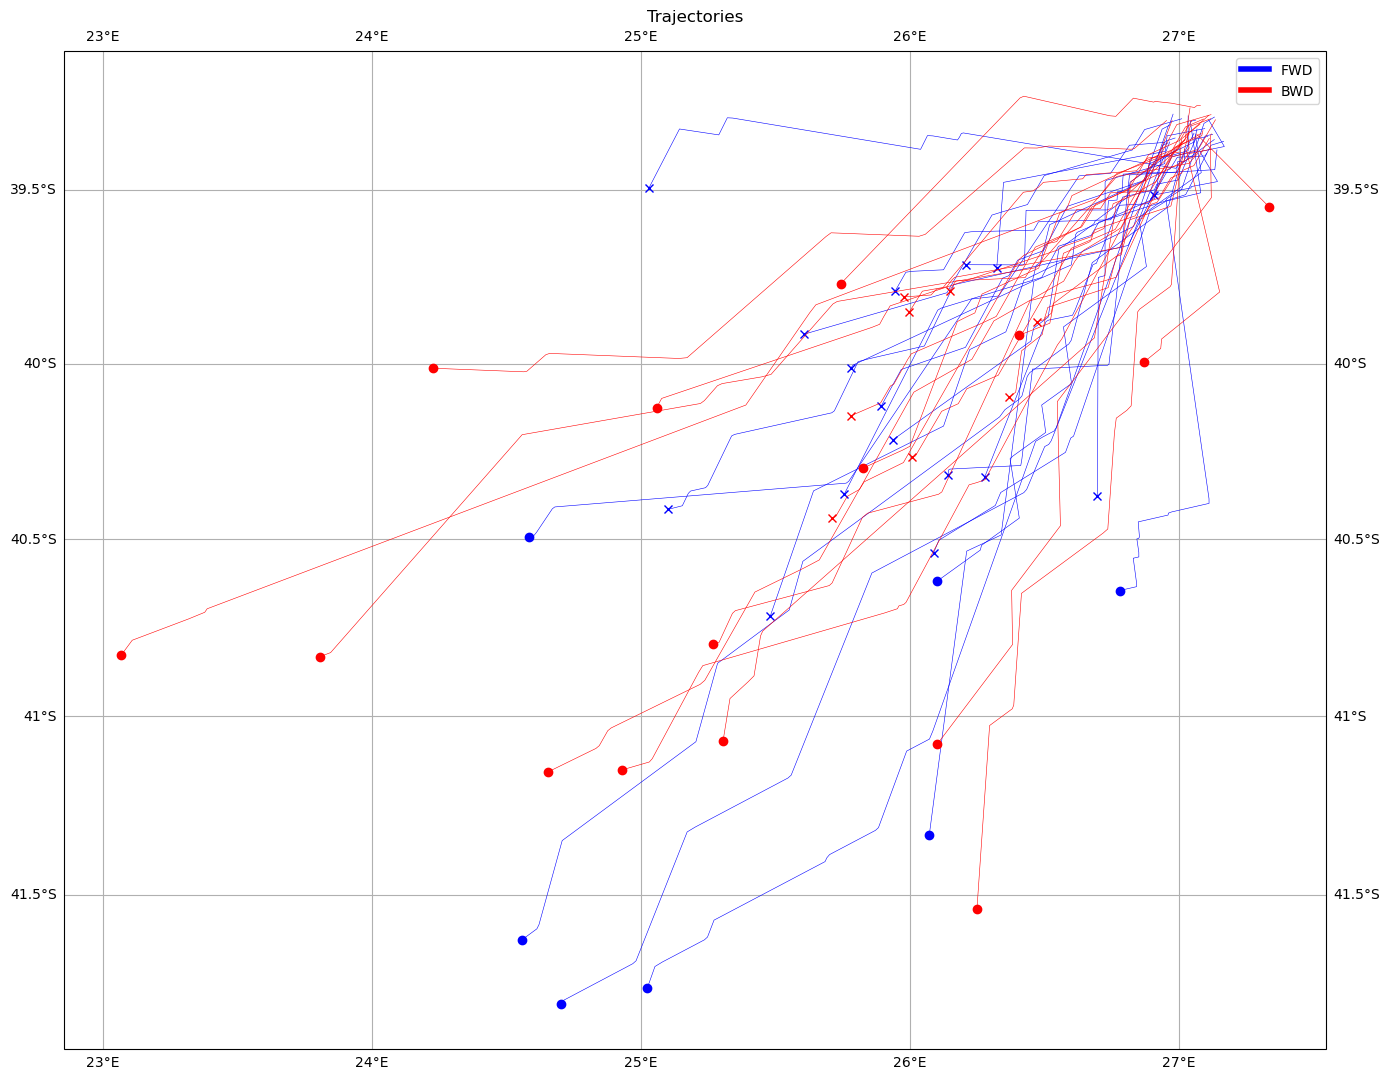

In [312]:
fig = plt.figure(figsize=(14,12))

ax = fig.add_subplot(projection=ccrs.Mercator())
ax.gridlines(draw_labels=True)

for i in range(len(xfwd.trajectory)):
    xfwd.isel(trajectory=i).traj.plot(linewidth=0.4, color='blue')
    if capsized_xfwd[i]<1:
        xfwd.isel(trajectory=i).isel(time=0).traj.plot(marker='o', color='blue')
    else: 
        xfwd.isel(trajectory=i).isel(time=0).traj.plot(marker='x', color='blue')

for i in range(len(bwd_truth.trajectory)):
    bwd_truth.isel(trajectory=i).traj.plot(linewidth=0.4, color='red')
    if capsized_bwd_truth[i]>0: 
        bwd_truth.isel(trajectory=i).isel(time=240).traj.plot(marker='x', color='red')
    else: 
        bwd_truth.isel(trajectory=i).isel(time=240).traj.plot(marker='o', color='red')
        
custom_lines = [Line2D([0], [0], color='blue', lw=4),
                Line2D([0], [0], color='red', lw=4),
                #Line2D([0], [0], color='grey', lw=4),
                #Line2D([0], [0], color='black', lw=4)
               ]

ax.legend(custom_lines, ['FWD', 'BWD'])

# plt.gca().autoscale()
plt.title('Trajectories')
plt.show()

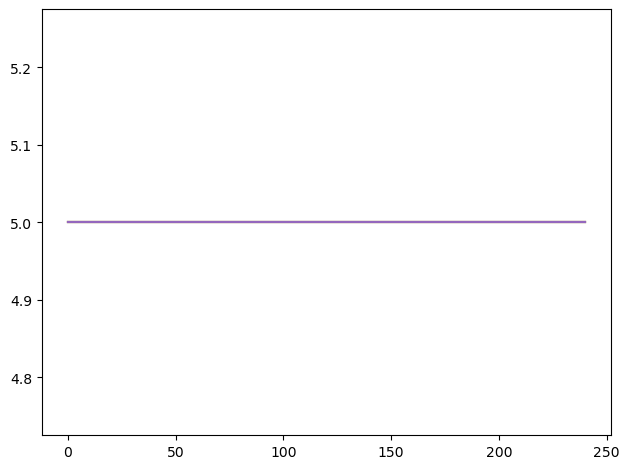

In [307]:
plt.plot(bwd_truth.isel(trajectory=0).x_wind)
plt.plot(bwd_truth.isel(trajectory=5).x_wind)
plt.plot(bwd_truth.isel(trajectory=10).x_wind)
plt.plot(bwd_truth.isel(trajectory=15).x_wind)
plt.plot(bwd_truth.isel(trajectory=20).x_wind)
# plt.plot(bwd_truth.isel(trajectory=25).x_wind)

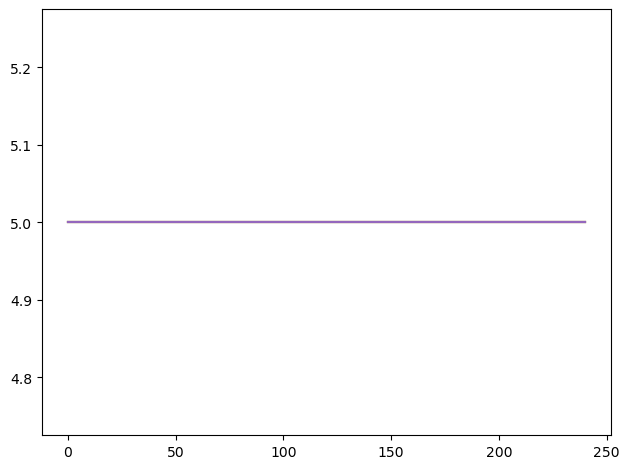

In [309]:
plt.plot(bwd_truth.isel(trajectory=0).y_wind)
plt.plot(bwd_truth.isel(trajectory=5).y_wind)
plt.plot(bwd_truth.isel(trajectory=10).y_wind)
plt.plot(bwd_truth.isel(trajectory=15).y_wind)
plt.plot(bwd_truth.isel(trajectory=20).y_wind)
# plt.plot(bwd_truth.isel(trajectory=25).y_wind)

In [310]:
wind = np.sqrt(np.square(xfwd.isel(trajectory=10).x_wind.values)+np.square(xfwd.isel(trajectory=10).y_wind.values))

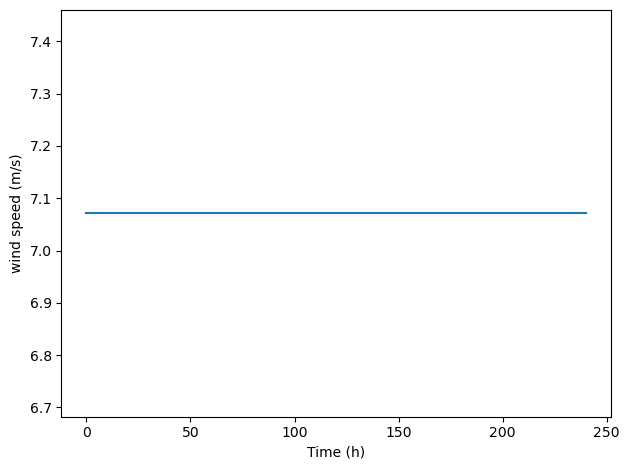

In [311]:
plt.plot(wind)
plt.xlabel('Time (h)')
plt.ylabel('wind speed (m/s)')

plt.savefig('wind_1424feb.png') 